## Main code

### Libraries and Modules

In [1]:
import sys
import math
import glob
import os
import time
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi
import cv2

import import_ipynb
import voronoi_constructor as vor_build
import vertices_assembler as assembler
import i_o

importing Jupyter notebook from voronoi_constructor.ipynb
importing Jupyter notebook from node_linker.ipynb
importing Jupyter notebook from solver.ipynb
                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Aug 23 01:22:05 PM: Your problem has 82 variables, 103 constraints, and 12 parameters.
(CVXPY) Aug 23 01:22:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 23 01:22:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 23 01:22:05 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 23 01:22:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

### Global Parameters

In [2]:
parameters = {"robots"      : 5,
              "radius"      : 1,
              "movement"    : 1,
              "tolerance"   : 0.5,
              "deadlock_mov": 1,
              "previous"    : 1
             }

### General Options

In [3]:
options = { "palette"    : vor_build.colors(parameters["robots"]),
            "verbose"    : 1,
            "optimize"   : 1,
            "plot"       : 1,
            "save_image" : 0,
            "save_data"  : 0,
            "experiments": 1,
            "seed"       : 0,
            "path_data"  : "/home/leduin/Escritorio/Tesis/Resultados/Datos/",
            "path_image" : "/home/leduin/Escritorio/Tesis/Imagenes/"
          }

### Main Loop

In [7]:
def main_module(key):
    with open(options["path_data"]+"aga_"+key+".csv", "a") as file:
        if options["save_data"]:
            csv_writer = csv.writer(file)
        for experiment in range(options["experiments"]):
            # INITIALIZATION
            start_time = time.time()
            inst_experiment = experiment+options["seed"]
            pos = vor_build.pos_gen(parameters["robots"], inst_experiment)
            vor_init = Voronoi(pos["init"])
            vor_fin  = Voronoi(pos["fin"])
            robots_path = [] # To save the robots path along execution
            finished = np.all(pos["init"] == pos["fin"]) 
            # To save the traveled distance of each robot 
            traveled_distances = [0 for _ in range(parameters["robots"])]
            counter = 0 # For steps
            
            # COLLISION FREE CONFIGURATION
            if vor_build.collision(pos["init"], vor_init.ridge_points,
                                   parameters["radius"]):
                print('ERROR!: Change the initial configuration')
                print("Positions:", vor_init.ridge_points)
                break
            if vor_build.collision(pos["fin"], vor_fin.ridge_points,
                                   parameters["radius"]):
                print('ERROR!: Change the final configuration')
                print("Positions:", vor_fin.ridge_points)
                break
                
            # MAIN LOOP
            while not finished:
                #Final iteration
                if np.all(pos["init"] == pos["fin"]):
                    finished = True
                if options["verbose"]:
                    print("==================================================")
                    print('                    MAIN DATA')
                    print("==================================================")
                    print('Robots:\n', pos["init"],'\n')
                    print('Final positions:\n', pos["fin"],'\n')
                # Generate Voronoi Diagram for the current positions
                vor_init = Voronoi(pos["init"])
                # Generate the Voronoi Diagram and get the approximated values
                # of inf vertices
                vor_approx = vor_build.voronoi_approx(pos["init"], vor_init,
                                                      options["verbose"])
                # Assemble the vertices and get the ordered vertices
                vrtx_assembled = assembler.main(parameters["robots"], vor_init,
                                                vor_approx["edge"],
                                                options["verbose"])
                robots_path.append(pos["init"]) # Save the previous position
                # Generate the BVC
                bvc = vor_build.bvc_gen(pos, parameters["radius"], vor_approx,
                                        vrtx_assembled, robots_path, options)
                i_o.save_image(options, parameters, counter)
                
                # DEADLOCK TESTING
                bvc["closer"],list_deadlock=vor_build.deadlock_test(parameters,
                                                                    options,
                                                                    bvc, pos,
                                                                    counter,
                                                                    robots_path)
                if options["verbose"]:
                    print('\nRounds: ',counter)
                    print('\n*-*-*-*-*-*-*-*ENDING ROUND*-*-*-*-*-*-*-*-*\n')
                counter += 1
                
                # UPDATING POSITIONS
                internal_paths = bvc["closer"] - pos["init"]
                new_positions = []
                for i in range(parameters["robots"]):
                    if np.all(internal_paths[i] == 0):
                        # Paralyzed Robot for deadlock
                        if i in list_deadlock: 
                            new_positions.append(bvc["closer"][i])
                        else: # Reached target
                            new_positions.append(pos["fin"][i])
                    else:
                        candidate = (pos["init"][i] +
                                     ((internal_paths[i]
                                       / np.linalg.norm(internal_paths[i]))
                                      * parameters["movement"]))
                        # Reaching the final position
                        if vor_build.isBetween(pos["init"][i], candidate,
                                                 pos["fin"][i]):
                            new_positions.append(pos["fin"][i])
                            traveled_distances[i]+=np.linalg.norm(pos["init"][i]
                                                                  - pos["fin"][i])
                        # Internal Path less than alpha
                        elif (np.linalg.norm(internal_paths[i])
                              < parameters["movement"]):
                            new_positions.append(bvc["closer"][i])
                            traveled_distances[i]+=np.linalg.norm(internal_paths[i])
                        # Normal movement
                        else:
                            new_positions.append(candidate)
                            traveled_distances[i] += parameters["movement"]
                pos["init"] = np.array(new_positions)
            effectiveness = np.sum(pos["dist"]) / np.sum(traveled_distances)
            if options["save_data"]:
                csv_writer.writerow([parameters[key], inst_experiment,
                                     counter, time.time() - start_time,
                                     effectiveness])
            print('Experiment ' + str(inst_experiment) + " done!")

### Running for the stablished number of experiments

                    MAIN DATA
Robots:
 [[ 29.4  -1.4]
 [  6.9  28.3]
 [-25.8  15.5]
 [-27.7 -19. ]
 [  4.9 -30.9]] 

Final positions:
 [[-33.6  -2.3]
 [-12.6 -30.6]
 [ 24.5 -20.9]
 [ 20.9  14. ]
 [-10.9  29.4]] 

List of vertex coordinates (including approximations) of Voronoi Diagram:
 [[  -0.58624473   -0.74412479]
 [  -3.4006829    -3.03590442]
 [  -0.75119709   -1.28290411]
 [  79.12297009   59.64164401]
 [ -37.03691661   92.37595102]
 [ -37.69064435  -96.97310974]
 [  76.17769919  -65.17300441]
 [-103.24937818    2.46300923]] 

Robots in front:  [[1 0]
 [1 2]
 [4 2]
 [4 3]
 [4 0]
 [2 0]
 [2 3]] 

Voronoi Diagram Edges:  [[3, 0], [4, 0], [1, 2], [5, 1], [6, 2], [0, 2], [7, 1]] 

             VORONOI VERTICES ASSEMBLY
Number of cells: 5 

******************************
Edge: [3, 0] ; Robots in front: [1, 0] 

Robot N° 1 

Analysis of vertex 3 in the cell: empty
Analysis of vertex 0 in the cell: empty 

Double linked list created! 3 ]---[ 0
3  
0  
Head: 3
Tail: 0
-------------------

TypeError: 'NoneType' object is not subscriptable

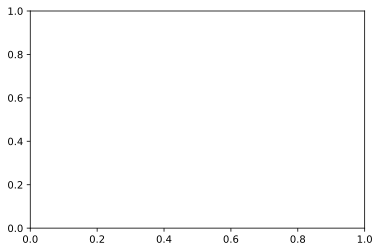

In [8]:
main_module("robots")

### One Parameter Analysis

In [15]:
parameter = "robots"
print("Working on",parameter,"...")
previous_value = parameters[parameter]
if parameter == "deadlock_mov":
    parameters[parameter] = 1
elif parameter == "tolerance":
    parameters[parameter] = 0.1
elif parameter == "movement":
    parameters[parameter] = 20
for i in range(10):
    print(parameter,"equal to",parameters[parameter],"...")
    main_module(parameter)
    if parameter == "tolerance":
        parameters[parameter] = round(parameters[parameter]+0.1,2)
    elif parameter == "movement":
        parameters[parameter] += 10 
    else:
        parameters[parameter] += 1
parameters[parameter] = previous_value

Working on num_robots ...
num_robots equal to 5 ...
num_robots equal to 6 ...
num_robots equal to 7 ...
num_robots equal to 8 ...


KeyboardInterrupt: 

### All Parameter Analysis

In [6]:
for parameter in parameters:
    print("Working on",parameter,"...")
    previous_value = parameters[parameter]
    if parameter == "deadlock_mov":
        parameters[parameter] = 1
    for i in range(10):
        print(parameter,"equal to",parameters[parameter],"...")
        main_module(parameter)
        parameters[parameter] += 1
    parameters[parameter] = previous_value

Working on radius ...
radius equal to 1 ...


voronoi_constructor.ipynb:16: RuntimeWarning: invalid value encountered in double_scalars
  },


radius equal to 2 ...
radius equal to 3 ...
radius equal to 4 ...
radius equal to 5 ...
radius equal to 6 ...
radius equal to 7 ...
radius equal to 8 ...
radius equal to 9 ...
radius equal to 10 ...
Working on movement ...
movement equal to 1 ...
movement equal to 2 ...
movement equal to 3 ...
movement equal to 4 ...
movement equal to 5 ...
movement equal to 6 ...
movement equal to 7 ...
movement equal to 8 ...
movement equal to 9 ...
movement equal to 10 ...
Working on tolerance ...
tolerance equal to 1 ...
tolerance equal to 2 ...
tolerance equal to 3 ...
tolerance equal to 4 ...
tolerance equal to 5 ...
tolerance equal to 6 ...
tolerance equal to 7 ...
tolerance equal to 8 ...
tolerance equal to 9 ...
tolerance equal to 10 ...
Working on deadlock_mov ...
deadlock_mov equal to 1 ...
deadlock_mov equal to 2 ...
deadlock_mov equal to 3 ...
deadlock_mov equal to 4 ...
deadlock_mov equal to 5 ...
deadlock_mov equal to 6 ...
deadlock_mov equal to 7 ...
deadlock_mov equal to 8 ...
deadlock

### Generate Video

In [11]:
frameSize = (432, 288)

out = cv2.VideoWriter('/home/leduin/Desktop/Hub/Images/Simple/animation_simple_'
                      +str(robots)+'.mp4',
                      cv2.VideoWriter_fourcc(*'DIVX'), 4, frameSize)

for filename in sorted(glob.glob('/home/leduin/Desktop/Hub/Images/Simple/'
                                 +str(robots)+'/*.png'),
                       key=os.path.getmtime):
    img = cv2.imread(filename)
    out.write(img)

out.release()